## Imports

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer ## for handling the missing values
import seaborn as sns ## for data visualization
from sklearn.model_selection import train_test_split

AttributeError: partially initialized module 'pandas' from 'c:\Users\Shefo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\__init__.py' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

## Get CSV File 

In [ ]:
filepath = '../data/California_Houses.csv'
df = pd.read_csv(filepath)

### Print 1st 5 Rows using head

In [61]:
print(df.columns.tolist())
print(df.head())
print(df.shape)

['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms', 'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         5

### Before Training the model, make sure there are no missing values in your dataset

In [62]:
print(df.isnull().sum())
## All values were zero meaning there are no null values in this dataset

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64


### Separate Features and Target Value

Mean House Value:  206855.81690891474


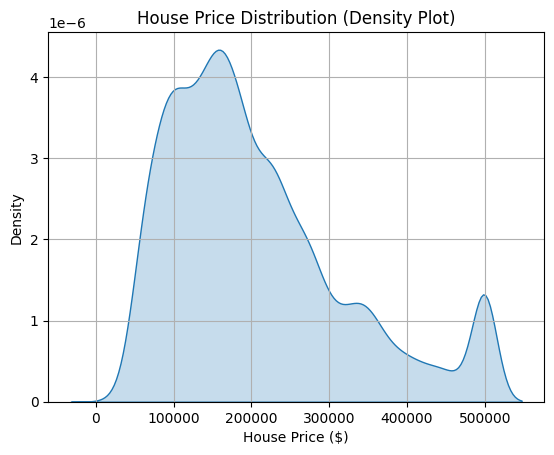

In [63]:
X= df.drop("Median_House_Value",axis=1)
# drop the target column(median house value) and leaving only the independent features

y=df["Median_House_Value"]
# y is the target value

print("Mean House Value: ",y.mean())

sns.kdeplot(data=df,x="Median_House_Value",fill=True)

plt.xlabel("House Price ($)")
plt.ylabel("Density")
plt.title("House Price Distribution (Density Plot)")
plt.grid(True)
plt.show()

Notice that there are some Outliers might need to exlude them to improve the accuracy

# Data Splitting

In [64]:
X_train, X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.30,random_state=42)

# train_test_split is used to split dataset into a training set and a temporary one
# to use again to split it to validation and test sets
X_validation,X_test,y_validation,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

print(X_train.shape)
print(y_train.shape) ## i want it to be (m,1)

(14448, 13)
(14448,)


In [10]:
##Reshape
y_train = np.array(y_train).reshape(-1, 1)
y_validation=np.array(y_validation).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1) # -1 means take the number of rows as it's 

print(y_train.shape)

(14448, 1)


## Scaling the data


In [11]:
# Scaling training
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

## Manual Linear Regression Implementation

In [12]:
def predict(X, w,b=None):
    # Compute predictions
    if b is None:
        X_b = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X_b, w) # working with y=X.w where X is design matrix
    else:
        return np.dot(X, w) + b
    

### Functions to Compute MAE , MSE

In [13]:
def compute_mae_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MAE (Mean Absolute Error)
    mae_cost = (1 / m) * np.sum(np.abs(y_pred - y))
    return mae_cost

def compute_mse_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MSE (Mean Square Error)
    mse_cost=(1 / (2*m) * np.sum((y_pred - y)** 2))
    return mse_cost

### Find Optimum Weights using Direct Solution

In [14]:
def normal_equation(X,y):
    X_b = np.hstack((np.ones((X.shape[0], 1)), X))  # (m, n+1)
    # Compute weights (w = (XᵀX)⁻¹Xᵀy)
    w = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return w

### Functions to Compute Gradient Descent

In [15]:
def compute_gradient(X,y,w,b):
    m=X.shape[0]
    y_pred=predict(X,w,b)
    dw = (1 / m) * np.dot(X.T, (y_pred - y))   # (n, 1)
    db = (1 / m) * np.sum(y_pred - y)         
    return dw, db
    

def gradient_descent(X,y,w,b,alpha,num_iterations):
    #update weights to minimize the cost
    mse_cost_history=[]
    
    for i in range(num_iterations):
        dw,db=compute_gradient(X,y,w,b)
        w = w - alpha * dw
        b = b - alpha * db
        mae_cost =compute_mae_cost(X,y,w,b)
        mse_cost =compute_mse_cost(X,y,w,b)
        mse_cost_history.append(mse_cost)
    
        # if i % 100 == 0:
        #     print(f"Iteration {i}, MSE Cost: {mse_cost:.4f},MAE Cost: {mae_cost:.4f}")
    return w,b,mse_cost_history

# Linear Regression Model Manually

In [16]:
def train_model(X,y,alpha,num_iterations):
    m,n=X.shape
    w=np.zeros((n,1))
    b=0
    w,b,cost_history=gradient_descent(X,y,w,b,alpha,num_iterations)
    return w,b,cost_history

def evaluate_model(X_test,y_test,w,b=None):
    #to compute MSE, MAE ON Test set after training
    y_pred=predict(X_test,w,b)
    mse=np.mean((y_test-y_pred)**2)
    mae=np.mean(np.abs(y_test-y_pred))
    return mse,mae


### Manual Linear Regression using Direct Solution to find Optimum weights

In [65]:

## All imports for this part
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Scaling training
scaler = StandardScaler()
scaler.fit(X_train)

### Evaluate Manual Linear Regression
mse_train,mae_train=evaluate_model(X_train_scaled,y_train,w,b)
mse_val,mae_val=evaluate_model(X_validation_scaled,y_validation,w,b)
mse_test,mae_test=evaluate_model(X_test_scaled,y_test,w,b)

print("Linear Regression (Manual Implementation) Performance:")
print(f"Train MSE: {mse_train:.2f},  MAE: {mae_train:.2f}")
print(f"Validation MSE: {mse_val:.2f},  MAE: {mae_val:.2f}")
print(f"Test MSE: {mse_test:.2f},  MAE: {mae_test:.2f}")

Linear Regression (Scikit-Learn) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


### Linear Regression Model using Direct Solution

In [35]:
#  Train the Linear Regression model
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_train_scaled, y_train)


# Predictions

In [ ]:
#  Predictions
y_pred_train_lin_sk = lin_reg_sk.predict(X_train_scaled)
y_pred_val_lin_sk   = lin_reg_sk.predict(X_validation_scaled)
y_pred_test_lin_sk  = lin_reg_sk.predict(X_test_scaled)

#  Compute mse - mae
mse_train_lin_sk = mean_squared_error(y_train, y_pred_train_lin_sk)
mae_train_lin_sk = mean_absolute_error(y_train, y_pred_train_lin_sk)

mse_val_lin_sk = mean_squared_error(y_validation, y_pred_val_lin_sk)
mae_val_lin_sk = mean_absolute_error(y_validation, y_pred_val_lin_sk)

mse_test_lin_sk = mean_squared_error(y_test, y_pred_test_lin_sk)
mae_test_lin_sk = mean_absolute_error(y_test, y_pred_test_lin_sk)

#  Display results of linear regression - STANDARD
print("Linear Regression (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_lin_sk:.2f},  MAE: {mae_train_lin_sk:.2f}")
print(f"Validation MSE: {mse_val_lin_sk:.2f},  MAE: {mae_val_lin_sk:.2f}")
print(f"Test MSE: {mse_test_lin_sk:.2f},  MAE: {mae_test_lin_sk:.2f}")

In [ ]:
# Hyperparameters
max_epochs = 200          # number of passes over training data
eta0 = 1e-3               # initial learning rate (for 'constant' or 'invscaling')
learning_schedule = 'invscaling'  # or 'constant' or 'optimal'
random_state = 42

# Regularization strengths to try for ridge/lasso using SGD (alpha in SGDRegressor)
alpha_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  # we'll later sweep these

# Setup three SGDRegressors for demonstration with a reasonable alpha (we'll sweep later)
sgd_plain = SGDRegressor(penalty='none', eta0=eta0, learning_rate=learning_schedule,
                         max_iter=1, tol=None, random_state=random_state, shuffle=True, warm_start=True)

sgd_ridge = SGDRegressor(penalty='l2', alpha=1e-4, eta0=eta0, learning_rate=learning_schedule,
                         max_iter=1, tol=None, random_state=random_state, shuffle=True, warm_start=True)

sgd_lasso = SGDRegressor(penalty='l1', alpha=1e-4, eta0=eta0, learning_rate=learning_schedule,
                         max_iter=1, tol=None, random_state=random_state, shuffle=True, warm_start=True)

# Containers to track validation MSE per epoch
val_mse_plain = []
val_mse_ridge = []
val_mse_lasso = []

# We must call partial_fit with classes shape for regression not needed; sklearn allows calling partial_fit for regression
# Important: partial_fit expects a single pass per call so we loop epochs and call partial_fit each epoch.

for epoch in range(max_epochs):
    # shuffle training data per epoch for SGD
    perm = np.random.RandomState(random_state + epoch).permutation(X_train_scaled.shape[0])
    X_shuf = X_train_scaled[perm]
    y_shuf = y_train.iloc[perm] if hasattr(y_train, "iloc") else y_train[perm]

    # Single epoch update
    sgd_plain.partial_fit(X_shuf, y_shuf)
    sgd_ridge.partial_fit(X_shuf, y_shuf)
    sgd_lasso.partial_fit(X_shuf, y_shuf)

    # Evaluate on validation set
    val_pred_plain = sgd_plain.predict(X_validation_scaled)
    val_pred_ridge = sgd_ridge.predict(X_validation_scaled)
    val_pred_lasso = sgd_lasso.predict(X_validation_scaled)

    val_mse_plain.append(mean_squared_error(y_validation, val_pred_plain))
    val_mse_ridge.append(mean_squared_error(y_validation, val_pred_ridge))
    val_mse_lasso.append(mean_squared_error(y_validation, val_pred_lasso))

# Plot learning curves
plt.figure(figsize=(9,5))
plt.plot(val_mse_plain, label='SGD Plain (no reg)')
plt.plot(val_mse_ridge, label='SGD Ridge (l2)')
plt.plot(val_mse_lasso, label='SGD Lasso (l1)')
plt.xlabel('Epoch')
plt.ylabel('Validation MSE')
plt.title('SGD Learning Curves (validation MSE)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'SGDRegressor' is not defined

### Linear Regression Model using Stochastic Gradient Descent

In [37]:
sgd_reg = SGDRegressor(max_iter=2000, tol=1e-3, eta0=0.001, learning_rate='constant', random_state=42)

# Train on scaled training data
sgd_reg.fit(X_train_scaled, y_train.ravel())

# Predictions
y_pred_train_sgd = sgd_reg.predict(X_train_scaled)
y_pred_val_sgd   = sgd_reg.predict(X_validation_scaled)
y_pred_test_sgd  = sgd_reg.predict(X_test_scaled)

In [38]:
mse_train_sgd = mean_squared_error(y_train, y_pred_train_sgd)
mae_train_sgd = mean_absolute_error(y_train, y_pred_train_sgd)

mse_val_sgd = mean_squared_error(y_validation, y_pred_val_sgd)
mae_val_sgd = mean_absolute_error(y_validation, y_pred_val_sgd)

mse_test_sgd = mean_squared_error(y_test, y_pred_test_sgd)
mae_test_sgd = mean_absolute_error(y_test, y_pred_test_sgd)

# Display results
print("\nSGD Regressor (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_sgd:.2f},  MAE: {mae_train_sgd:.2f}")
print(f"Validation MSE: {mse_val_sgd:.2f},  MAE: {mae_val_sgd:.2f}")
print(f"Test MSE: {mse_test_sgd:.2f},  MAE: {mae_test_sgd:.2f}")


SGD Regressor (Scikit-Learn) Performance:
Train MSE: 4791585159.62,  MAE: 49832.61
Validation MSE: 5015284977.14,  MAE: 50884.71
Test MSE: 4455736305.29,  MAE: 48738.22


### Comparing the Performance of Sickit-Learn and Manual Implementation

#### Linear Regression (Scikit-Learn) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

#### Linear Regression (Manual Implementation) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

Results are quite close

# Ridge Regression — Validation Error vs. α

In [ ]:
# ridge regression -> for regularization & overfitting the model
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_mse = []
ridge_mae = []

for a in alphas:
    ridge= Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_validation_scaled)
    
    ridge_mse.append(mean_squared_error(y_validation, y_pred_val))
    ridge_mae.append(mean_absolute_error(y_validation, y_pred_val))



# Plotting mean squared error


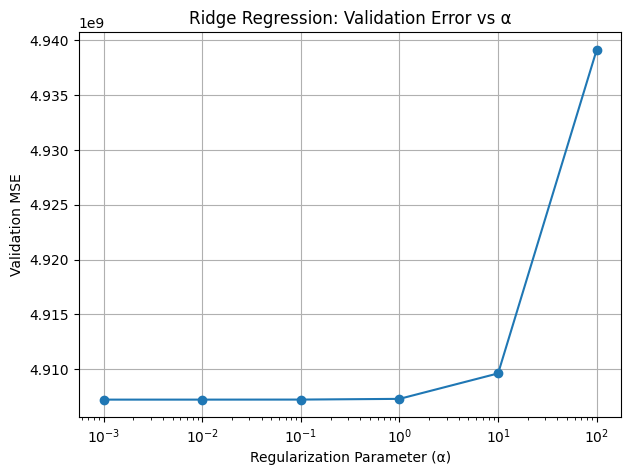

In [ ]:

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, ridge_mse, marker='o')
plt.xscale('log')
plt.title("Ridge Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()

Ridge regression successfully reduced overfitting by penalizing large coefficient values. As α increased, validation error first decreased then rose again, indicating the trade-off between bias and variance. Compared to standard Linear Regression, Ridge showed more stable and generalizable performance. However, unlike Lasso, Ridge retains all features, making it more suitable when all predictors are expected to contribute meaningfully

# Lasso Regression — Validation Error vs. α

In [ ]:
# lasso regression -> for regularization of absolute weights
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
lasso_mse = []
lasso_mae = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred_val = lasso.predict(X_validation_scaled)
    
    lasso_mse.append(mean_squared_error(y_validation, y_pred_val))
    lasso_mae.append(mean_absolute_error(y_validation, y_pred_val))


# Plotting the mean absolute error

In [ ]:

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, lasso_mse, marker='o', color='orange')
plt.xscale('log')
plt.title("Lasso Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()


Lasso regression improved model generalization by applying L1 regularization, which penalizes large coefficients and forces some to zero. This led to a simpler and more interpretable model. As α increased, validation error first decreased (reduced overfitting) and then increased (underfitting). Compared to Ridge, Lasso can perform automatic feature selection, making it particularly useful when dealing with high-dimensional data.

# Final Comparison and Discussion: Linear vs Ridge vs Lasso Regression

In this experiment, three regression techniques—Linear Regression, Ridge Regression "L2" and Lasso Regression "L1" were implemented and compared based on their performance in terms of Mean Squared Error (MSE) and Mean Absolute Error (MAE) on the validation dataset.

The standard Linear Regression model provided a baseline for comparison. While it captured the general trend in the data, it tended to overfit, especially when the dataset contained noise or correlated features, as it does not include any regularization to control model complexity.

-> Ridge Regression, which applies L2 regularization, improved generalization by penalizing large coefficient values and reducing model variance. It effectively handled multicollinearity among features but kept all features in the model. As the regularization parameter (α) increased, the model’s coefficients were shrunk towards zero, reducing overfitting. However, too large an α led to underfitting, increasing the validation error again.

-> Lasso Regression, using L1 regularization, not only reduced overfitting but also performed feature selection by driving some coefficients exactly to zero. This resulted in a simpler, more interpretable model that focused on the most significant predictors. Lasso performed best when the dataset likely contained irrelevant or redundant features, achieving a balance between bias and variance.

